# Pricing Optimization Challenge Analysis

This notebook implements a comprehensive pricing optimization analysis using polars for data manipulation, statistical modeling for price elasticity calculation, and dynamic pricing simulation to maximize profits.

## Objective:
Your client is an e-commerce business looking to improve its profitability. They suspect they are leaving money on the table by not pricing dynamically. Your task is to analyze their sales data and recommend a pricing strategy that maximizes profit by modeling price elasticity and forecasting demand changes.

## Methodology Overview
1. **Data Loading & Cleaning**: Load ecommerce sales data and prepare it for analysis
2. **Data Aggregation**: Group data by SKU (Style) and week to create time series for modeling
3. **Price Elasticity Modeling**: Use log-log OLS regression to calculate demand elasticity at Category type and Price segment level
4. **Dynamic Pricing Simulation**: Calculate optimal prices and simulate profit improvements
5. **Evaluation & Recommendations**: Analyze results and provide actionable insights

## 1. Environment Setup and Library Imports

Import required libraries and set up the analysis environment. We'll use polars as the primary data manipulation library for performance and clarity.

In [1]:
# Import required libraries
import polars as pl
import pandas as pd
import polars_ds as plds
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# make all jupyter output visible
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# polars and pandas configure to show 25 rows and all columns
pl.Config.set_tbl_rows(25)
pl.Config.set_tbl_cols(100)
# pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Define file paths for available datasets
data_files = {
    "amazon_sales": "data/Amazon Sale Report.csv",
    "international_sales": "data/International sale Report.csv", 
    "pl_march": "data/P & L March 2021.csv",
    "may_pricing": "data/May-2022.csv",
    "sale_report": "data/Sale Report.csv",
    "warehouse_comparison": "data/Cloud Warehouse Compersion Chart.csv",
    "expenses": "data/Expense IIGF.csv"
}

print("Libraries imported successfully!")
print(f"Polars version: {pl.__version__}")
print("\nAvailable datasets:")
for key, path in data_files.items():
    print(f"- {key}: {path}")

Libraries imported successfully!
Polars version: 1.33.1

Available datasets:
- amazon_sales: data/Amazon Sale Report.csv
- international_sales: data/International sale Report.csv
- pl_march: data/P & L March 2021.csv
- may_pricing: data/May-2022.csv
- sale_report: data/Sale Report.csv
- warehouse_comparison: data/Cloud Warehouse Compersion Chart.csv
- expenses: data/Expense IIGF.csv


## 2. Data Loading and Initial Inspection

Load the CSV file into a polars DataFrame and perform initial data exploration to understand the structure, data types, and basic statistics.

In [2]:
# Load and explore the primary datasets for pricing analysis
def load_datasets() -> Dict[str, pl.DataFrame]:
    """Load all available datasets and return as dictionary."""
    datasets = {}
    
    # Correct file paths (note the spacing in P&L filename)
    files_dict = {
        "amazon_sales": "data/Amazon Sale Report.csv",
        "international_sales": "data/International sale Report.csv", 
        "pl_march": "data/P  L March 2021.csv",
        "may_pricing": "data/May-2022.csv",
        "sale_report": "data/Sale Report.csv",
        "warehouse_comparison": "data/Cloud Warehouse Compersion Chart.csv",
        "expenses": "data/Expense IIGF.csv"
    }
    
    null_values = ["Nill", "NULL", "null", ""]
    
    for name, path in files_dict.items():
            try:
                df = pl.read_csv(path, null_values=null_values)
            except Exception as e:
                try:
                    df = pl.read_csv(path, null_values=null_values, infer_schema_length=None)
                except Exception as e:
                    print(f"Failed to load {name} even with schema inference: {e}")
                    continue
            
            # drop "index" column if exists
            if "index" in df.columns:
                df = df.drop("index")
            
            datasets[name] = df
            print(f"Loaded {name}: {df.shape} (rows, cols)")
    return datasets

# Load all datasets
datasets = load_datasets()

print(f"\nSuccessfully loaded {len(datasets)} datasets")

# Display basic info for datasets
key_datasets = ["amazon_sales", "international_sales", "pl_march", "may_pricing"]
for name in key_datasets:
        print(f"\n=== {name.upper().replace('_', ' ')} DATASET ===")
        df = datasets[name]
        df
        # print(df.head())
        # print("Description:")
        # print(df.describe())

Loaded amazon_sales: (128975, 23) (rows, cols)
Loaded international_sales: (37432, 9) (rows, cols)
Loaded pl_march: (1330, 17) (rows, cols)
Loaded may_pricing: (1330, 16) (rows, cols)
Loaded sale_report: (9271, 6) (rows, cols)
Loaded warehouse_comparison: (50, 3) (rows, cols)
Loaded expenses: (17, 4) (rows, cols)

Successfully loaded 7 datasets

=== AMAZON SALES DATASET ===


Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,Qty,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
str,str,str,str,str,str,str,str,str,str,str,str,i64,str,f64,str,str,f64,str,str,bool,str,str
"""405-8078784-5731545""","""04-30-22""","""Cancelled""","""Merchant""","""Amazon.in""","""Standard""","""SET389""","""SET389-KR-NP-S""","""Set""","""S""","""B09KXVBD7Z""",null,0,"""INR""",647.62,"""MUMBAI""","""MAHARASHTRA""",400081.0,"""IN""",null,false,"""Easy Ship""",null
"""171-9198151-1101146""","""04-30-22""","""Shipped - Delivered to Buyer""","""Merchant""","""Amazon.in""","""Standard""","""JNE3781""","""JNE3781-KR-XXXL""","""kurta""","""3XL""","""B09K3WFS32""","""Shipped""",1,"""INR""",406.0,"""BENGALURU""","""KARNATAKA""",560085.0,"""IN""","""Amazon PLCC Free-Financing Uni…",false,"""Easy Ship""",null
"""404-0687676-7273146""","""04-30-22""","""Shipped""","""Amazon""","""Amazon.in""","""Expedited""","""JNE3371""","""JNE3371-KR-XL""","""kurta""","""XL""","""B07WV4JV4D""","""Shipped""",1,"""INR""",329.0,"""NAVI MUMBAI""","""MAHARASHTRA""",410210.0,"""IN""","""IN Core Free Shipping 2015/04/…",true,null,null
"""403-9615377-8133951""","""04-30-22""","""Cancelled""","""Merchant""","""Amazon.in""","""Standard""","""J0341""","""J0341-DR-L""","""Western Dress""","""L""","""B099NRCT7B""",null,0,"""INR""",753.33,"""PUDUCHERRY""","""PUDUCHERRY""",605008.0,"""IN""",null,false,"""Easy Ship""",null
"""407-1069790-7240320""","""04-30-22""","""Shipped""","""Amazon""","""Amazon.in""","""Expedited""","""JNE3671""","""JNE3671-TU-XXXL""","""Top""","""3XL""","""B098714BZP""","""Shipped""",1,"""INR""",574.0,"""CHENNAI""","""TAMIL NADU""",600073.0,"""IN""",null,false,null,null
"""404-1490984-4578765""","""04-30-22""","""Shipped""","""Amazon""","""Amazon.in""","""Expedited""","""SET264""","""SET264-KR-NP-XL""","""Set""","""XL""","""B08YN7XDSG""","""Shipped""",1,"""INR""",824.0,"""GHAZIABAD""","""UTTAR PRADESH""",201102.0,"""IN""","""IN Core Free Shipping 2015/04/…",false,null,null
"""408-5748499-6859555""","""04-30-22""","""Shipped""","""Amazon""","""Amazon.in""","""Expedited""","""J0095""","""J0095-SET-L""","""Set""","""L""","""B08CMHNWBN""","""Shipped""",1,"""INR""",653.0,"""CHANDIGARH""","""CHANDIGARH""",160036.0,"""IN""","""IN Core Free Shipping 2015/04/…",false,null,null
"""406-7807733-3785945""","""04-30-22""","""Shipped - Delivered to Buyer""","""Merchant""","""Amazon.in""","""Standard""","""JNE3405""","""JNE3405-KR-S""","""kurta""","""S""","""B081WX4G4Q""","""Shipped""",1,"""INR""",399.0,"""HYDERABAD""","""TELANGANA""",500032.0,"""IN""","""Amazon PLCC Free-Financing Uni…",false,"""Easy Ship""",null
"""407-5443024-5233168""","""04-30-22""","""Cancelled""","""Amazon""","""Amazon.in""","""Expedited""","""SET200""","""SET200-KR-NP-A-XXXL""","""Set""","""3XL""","""B08L91ZZXN""","""Cancelled""",0,null,null,"""HYDERABAD""","""TELANGANA""",500008.0,"""IN""","""IN Core Free Shipping 2015/04/…",false,null,null



=== INTERNATIONAL SALES DATASET ===


DATE,Months,CUSTOMER,Style,SKU,Size,PCS,RATE,GROSS AMT
str,str,str,str,str,str,str,str,str
"""06-05-21""","""Jun-21""","""REVATHY LOGANATHAN""","""MEN5004""","""MEN5004-KR-L""","""L""","""1.00""","""616.56""","""617.00"""
"""06-05-21""","""Jun-21""","""REVATHY LOGANATHAN""","""MEN5004""","""MEN5004-KR-XL""","""XL""","""1.00""","""616.56""","""617.00"""
"""06-05-21""","""Jun-21""","""REVATHY LOGANATHAN""","""MEN5004""","""MEN5004-KR-XXL""","""XXL""","""1.00""","""616.56""","""617.00"""
"""06-05-21""","""Jun-21""","""REVATHY LOGANATHAN""","""MEN5009""","""MEN5009-KR-L""","""L""","""1.00""","""616.56""","""617.00"""
"""06-05-21""","""Jun-21""","""REVATHY LOGANATHAN""","""MEN5011""","""MEN5011-KR-L""","""L""","""1.00""","""616.56""","""617.00"""
"""06-05-21""","""Jun-21""","""REVATHY LOGANATHAN""","""MEN5025""","""MEN5025-KR-L""","""L""","""1.00""","""649.03""","""649.00"""
"""06-05-21""","""Jun-21""","""REVATHY LOGANATHAN""","""MEN5015""","""MEN5015-KR-XL""","""XL""","""1.00""","""616.56""","""617.00"""
"""06-05-21""","""Jun-21""","""REVATHY LOGANATHAN""","""MEN5022""","""MEN5022-KR-XXL""","""XXL""","""1.00""","""649.03""","""649.00"""
"""06-05-21""","""Jun-21""","""REVATHY LOGANATHAN""","""MEN5014""","""MEN5014-KR-S""","""S""","""1.00""","""649.03""","""649.00"""



=== PL MARCH DATASET ===


Sku,Style Id,Catalog,Category,Weight,TP 1,TP 2,MRP Old,Final MRP Old,Ajio MRP,Amazon MRP,Amazon FBA MRP,Flipkart MRP,Limeroad MRP,Myntra MRP,Paytm MRP,Snapdeal MRP
str,str,str,str,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Os206_3141_S""","""Os206_3141""","""Moments""","""Kurta""",0.3,"""538""","""435.78""",2178.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0
"""Os206_3141_M""","""Os206_3141""","""Moments""","""Kurta""",0.3,"""538""","""435.78""",2178.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0
"""Os206_3141_L""","""Os206_3141""","""Moments""","""Kurta""",0.3,"""538""","""435.78""",2178.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0
"""Os206_3141_XL""","""Os206_3141""","""Moments""","""Kurta""",0.3,"""538""","""435.78""",2178.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0
"""Os206_3141_2XL""","""Os206_3141""","""Moments""","""Kurta""",0.3,"""538""","""435.78""",2178.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0
"""Os206_3141_3XL""","""Os206_3141""","""Moments""","""Kurta""",0.3,"""538""","""435.78""",2178.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0
"""Os223_3142_S""","""Os223_3142""","""Moments""","""Kurta""",0.3,"""538""","""435.78""",2178.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0
"""Os223_3142_M""","""Os223_3142""","""Moments""","""Kurta""",0.3,"""538""","""435.78""",2178.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0
"""Os223_3142_L""","""Os223_3142""","""Moments""","""Kurta""",0.3,"""538""","""435.78""",2178.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0



=== MAY PRICING DATASET ===


Sku,Style Id,Catalog,Category,Weight,TP,MRP Old,Final MRP Old,Ajio MRP,Amazon MRP,Amazon FBA MRP,Flipkart MRP,Limeroad MRP,Myntra MRP,Paytm MRP,Snapdeal MRP
str,str,str,str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Os206_3141_S""","""Os206_3141""","""Moments""","""Kurta""",0.3,"""538""",2178.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0
"""Os206_3141_M""","""Os206_3141""","""Moments""","""Kurta""",0.3,"""538""",2178.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0
"""Os206_3141_L""","""Os206_3141""","""Moments""","""Kurta""",0.3,"""538""",2178.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0
"""Os206_3141_XL""","""Os206_3141""","""Moments""","""Kurta""",0.3,"""538""",2178.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0
"""Os206_3141_2XL""","""Os206_3141""","""Moments""","""Kurta""",0.3,"""538""",2178.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0
"""Os206_3141_3XL""","""Os206_3141""","""Moments""","""Kurta""",0.3,"""538""",2178.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0
"""Os223_3142_S""","""Os223_3142""","""Moments""","""Kurta""",0.3,"""538""",2178.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0
"""Os223_3142_M""","""Os223_3142""","""Moments""","""Kurta""",0.3,"""538""",2178.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0
"""Os223_3142_L""","""Os223_3142""","""Moments""","""Kurta""",0.3,"""538""",2178.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0,2295.0


In [3]:
# Limit this analysis to Amazon sales data only
# get the sales df
sales_df = datasets.get("amazon_sales")

# valid sales flag
sale_cond = (
    pl.col("Status").is_in([
        "Shipped",
        "Shipped - Delivered to Buyer",
        "Shipped - Picked Up",
        "Shipped - Out for Delivery",
        "Shipping"
    ]) 
    # qty & amount positive
    & pl.col("Amount").gt(0)
    & pl.col("Qty").gt(0)
)

# get unit price
sales_df = sales_df.with_columns([
    # if qty is 0, set unit price to 0 to avoid division by zero
    pl.when(pl.col("Qty") == 0).then(0).otherwise(
        (pl.col("Amount").truediv(pl.col("Qty")))
    ).alias("unit_price"),
    
    sale_cond.alias("valid_sale")
]).sort(
    ["valid_sale", "Date"], descending=[True, True]
).unique(subset=["Order ID"], keep="first")

sales_df.shape, sales_df["Order ID"].n_unique()

sales_df.head()

((120378, 25), 120378)

Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,Qty,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22,unit_price,valid_sale
str,str,str,str,str,str,str,str,str,str,str,str,i64,str,f64,str,str,f64,str,str,bool,str,str,f64,bool
"""402-5470365-7689957""","""05-23-22""","""Cancelled""","""Amazon""","""Amazon.in""","""Expedited""","""J0277""","""J0277-SKD-XL""","""Set""","""XL""","""B08QGLBXXQ""","""Cancelled""",0,null,null,"""JAMMU""","""JAMMU & KASHMIR""",180010.0,"""IN""",null,false,null,"""False""",0.0,false
"""171-9637641-4333125""","""05-09-22""","""Shipped""","""Amazon""","""Amazon.in""","""Expedited""","""JNE2100""","""JNE2100-KR-144-XL""","""kurta""","""XL""","""B078Q4CFFN""","""Shipped""",1,"""INR""",382.0,"""NEW DELHI""","""DELHI""",110029.0,"""IN""","""IN Core Free Shipping 2015/04/…",false,null,"""False""",382.0,true
"""403-3971590-5701117""","""04-22-22""","""Shipped - Delivered to Buyer""","""Merchant""","""Amazon.in""","""Standard""","""SET363""","""SET363-KR-NP-XL""","""Set""","""XL""","""B09TH6N96L""","""Shipped""",1,"""INR""",1338.0,"""BALAGHAT""","""MADHYA PRADESH""",481001.0,"""IN""","""Amazon PLCC Free-Financing Uni…",false,"""Easy Ship""",null,1338.0,true
"""402-1430873-6110702""","""04-22-22""","""Shipped - Delivered to Buyer""","""Merchant""","""Amazon.in""","""Standard""","""SET183""","""SET183-KR-DH-M""","""Set""","""M""","""B08B3Z2YY3""","""Shipped""",1,"""INR""",759.0,"""BENGALURU""","""KARNATAKA""",560040.0,"""IN""","""Amazon PLCC Free-Financing Uni…",false,"""Easy Ship""",null,759.0,true
"""407-0167436-4557908""","""06-05-22""","""Shipped - Returned to Seller""","""Merchant""","""Amazon.in""","""Standard""","""J0352""","""J0352-KR-L""","""kurta""","""L""","""B098114JLC""","""Shipped""",1,"""INR""",666.0,"""NELLORE""","""ANDHRA PRADESH""",524003.0,"""IN""","""Amazon PLCC Free-Financing Uni…",false,"""Easy Ship""","""False""",666.0,false


In [4]:
# sales df1 with only valid sales
sales_df1 = sales_df.filter(pl.col("valid_sale"))

def get_distribution(df: pl.DataFrame, key : list) -> pl.DataFrame:
    """Get distribution of values for specified key columns."""
    dist_df = df.group_by(key).agg(
        pl.count(),
        (pl.count() * 100.0 / df.height).alias("percent"),
        # get the average unit price for the group
        pl.col("Amount").sum().alias("total_amount"),
        pl.col("Qty").sum().alias("total_qty"),
        (pl.col("Amount").sum() / pl.col("Qty").sum()).alias("avg_unit_price")
    ).sort("count", descending=True)
    return dist_df

# get val counts for category
get_distribution(sales_df1, ["Category"])
get_distribution(sales_df1, ["Size"])
get_distribution(sales_df1, ["Category", "Size"])
# get val counts for status
get_distribution(sales_df1, ["Status"])
style_dist = get_distribution(sales_df1, ["Category", "Style"])
style_dist

Category,count,percent,total_amount,total_qty,avg_unit_price
str,u32,f64,f64,i64,f64
"""Set""",38159,38.951666,3.2611474e7,38257,852.431555
"""kurta""",37302,38.076864,1.7432297e7,37457,465.394906
"""Western Dress""",11996,12.24519,9.327495e6,12026,775.61076
"""Top""",8434,8.609197,4.508978e6,8457,533.165189
"""Ethnic Dress""",885,0.903384,657373.0,887,741.119504
"""Blouse""",737,0.752309,393857.0,743,530.090175
"""Bottom""",331,0.337876,122449.0,334,366.613772
"""Saree""",120,0.122493,96671.0,122,792.385246
"""Dupatta""",1,0.001021,305.0,1,305.0


Size,count,percent,total_amount,total_qty,avg_unit_price
str,u32,f64,f64,i64,f64
"""M""",17223,17.580769,1.1525077e7,17275,667.153517
"""L""",16731,17.078548,1.0969814e7,16780,653.743385
"""XL""",15977,16.308886,1.0373542e7,16027,647.254134
"""XXL""",13874,14.162201,8.886146e6,13936,637.639638
"""S""",12861,13.128158,8.79924e6,12894,682.429037
"""3XL""",11371,11.607207,7.565049e6,11408,663.135431
"""XS""",8266,8.437707,5.734258e6,8293,691.457615
"""6XL""",588,0.600214,486879.0,588,828.02551
"""5XL""",449,0.458327,367635.0,450,816.966667


Category,Size,count,percent,total_amount,total_qty,avg_unit_price
str,str,u32,f64,f64,i64,f64
"""Set""","""M""",7114,7.261777,6.07533e6,7129,852.199467
"""kurta""","""L""",6606,6.743225,3.036834e6,6631,457.975268
"""kurta""","""XL""",6540,6.675854,2.988005e6,6565,455.14166
"""kurta""","""M""",6366,6.498239,2.911283e6,6392,455.45729
"""Set""","""L""",6229,6.358393,5.295326e6,6243,848.202146
"""Set""","""XL""",5819,5.939876,4.960102e6,5837,849.769059
"""kurta""","""XXL""",5760,5.879651,2.651427e6,5798,457.300276
"""Set""","""S""",5681,5.79901,4.895032e6,5692,859.98454
"""Set""","""XXL""",4686,4.783341,3.988178e6,4698,848.909749


Status,count,percent,total_amount,total_qty,avg_unit_price
str,u32,f64,f64,i64,f64
"""Shipped""",71193,72.671873,4.7218103e7,71411,661.216101
"""Shipped - Delivered to Buyer""",25850,26.386975,1.7286071e7,25947,666.206922
"""Shipped - Picked Up""",890,0.908488,622878.0,894,696.731544
"""Shipped - Out for Delivery""",32,0.032665,23847.0,32,745.21875


Category,Style,count,percent,total_amount,total_qty,avg_unit_price
str,str,u32,f64,f64,i64,f64
"""Western Dress""","""JNE3797""",3177,3.242995,2.382112e6,3187,747.446501
"""kurta""","""JNE3405""",1784,1.821059,735200.0,1798,408.898776
"""Set""","""J0230""",1486,1.516868,1.71758e6,1491,1151.965124
"""Set""","""SET268""",1459,1.489307,1.131312e6,1464,772.754098
"""Western Dress""","""J0341""",1308,1.335171,1.094768e6,1311,835.06331
"""Set""","""J0003""",1189,1.213699,802025.0,1195,671.150628
"""Set""","""SET345""",969,0.989129,617358.0,971,635.796087
"""Set""","""SET324""",947,0.966672,583317.0,949,614.66491
"""kurta""","""JNE3373""",931,0.950339,352786.0,934,377.715203


In [5]:
"""
Create style df:
ID - Style
Dimensions
1. Category
2. Category_Type
Metrics:
1. avg_unit_price
"""
category_type_dict = {
    "B) Set" : ["Set"],
    "C) Kurta" : ["kurta"],
    "A) Dress" : ["Western Dress", "Ethnic Dress"],
    "D) Top" : ["Top", "Blouse"],
}
# create replace dict from above
category_type_dict = {k: v for v in category_type_dict for k in category_type_dict[v]}

style_df = get_distribution(sales_df1, ["Category", "Style"])

style_df = style_df.with_columns([
    pl.col("Category").replace_strict(category_type_dict, default="Z) Other").alias("Category_Type")
])
style_df

'\nCreate style df:\nID - Style\nDimensions\n1. Category\n2. Category_Type\nMetrics:\n1. avg_unit_price\n'

Category,Style,count,percent,total_amount,total_qty,avg_unit_price,Category_Type
str,str,u32,f64,f64,i64,f64,str
"""Western Dress""","""JNE3797""",3177,3.242995,2.382112e6,3187,747.446501,"""A) Dress"""
"""kurta""","""JNE3405""",1784,1.821059,735200.0,1798,408.898776,"""C) Kurta"""
"""Set""","""J0230""",1486,1.516868,1.71758e6,1491,1151.965124,"""B) Set"""
"""Set""","""SET268""",1459,1.489307,1.131312e6,1464,772.754098,"""B) Set"""
"""Western Dress""","""J0341""",1308,1.335171,1.094768e6,1311,835.06331,"""A) Dress"""
"""Set""","""J0003""",1189,1.213699,802025.0,1195,671.150628,"""B) Set"""
"""Set""","""SET345""",969,0.989129,617358.0,971,635.796087,"""B) Set"""
"""Set""","""SET324""",947,0.966672,583317.0,949,614.66491,"""B) Set"""
"""kurta""","""JNE3373""",931,0.950339,352786.0,934,377.715203,"""C) Kurta"""


In [6]:
# assume cost price is 60% of avg unit price
style_df = style_df.with_columns([
    (pl.col("avg_unit_price") * 0.6).alias("cost_price")
])

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='Category_Type', ylabel='total_qty'>

Text(0.5, 1.0, 'Distribution of Quantity sold by Price Segment for Each Category Type of Styles')

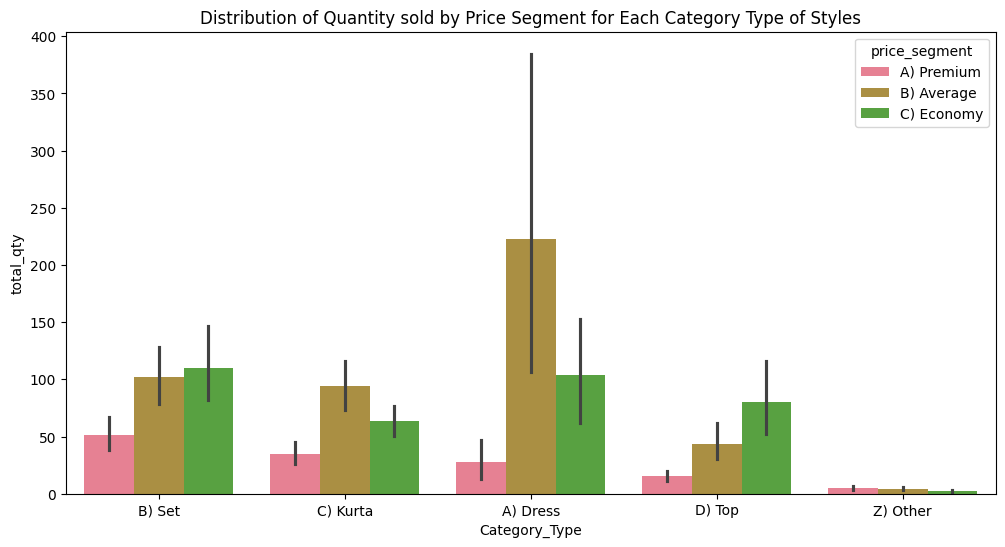

In [7]:
# within each category, get the weighted percentile (25th, 75th) of avg_unit_price
style_df = style_df.with_columns([
    pl.col("avg_unit_price").quantile(0.25).over("Category_Type").alias("p25_avg_unit_price"),
    pl.col("avg_unit_price").quantile(0.75).over("Category_Type").alias("p75_avg_unit_price"),
]).with_columns([
    # flag if avg_unit_price is below 25th percentile or above 75th percentile
    pl.when(pl.col("avg_unit_price") < pl.col("p25_avg_unit_price")).then(pl.lit("A) Premium"))
        .when(pl.col("avg_unit_price") > pl.col("p75_avg_unit_price")).then(pl.lit("C) Economy"))
        .otherwise(pl.lit("B) Average")).alias("price_segment")
])

# plot the distribution of styles by price segment for each category type - plot the total_qty as bar height and in a single clustered bar chart
plt.figure(figsize=(12, 6))
# make sure that the price_segment order is A, B, C
style_df = style_df.sort("price_segment")
sns.barplot(data=style_df, x="Category_Type", y="total_qty", hue="price_segment")
plt.title("Distribution of Quantity sold by Price Segment for Each Category Type of Styles")

## 3. Data Aggregation for Modeling

Create weekly aggregations by Style to prepare time series data for elasticity modeling. This aggregation ensures we have sufficient data points for reliable statistical analysis.

In [8]:
# join back to sales_df1 to get the price segment for each sale
sales_df1.shape
sales_df2 = sales_df1.join(
    style_df.select(["Category", "Style", "Category_Type", "price_segment", "avg_unit_price", "cost_price"]),
    on=["Category", "Style"],
    how="left"
)
sales_df2.shape
sales_df2.head()

(97965, 25)

(97965, 29)

Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,Qty,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22,unit_price,valid_sale,Category_Type,price_segment,avg_unit_price,cost_price
str,str,str,str,str,str,str,str,str,str,str,str,i64,str,f64,str,str,f64,str,str,bool,str,str,f64,bool,str,str,f64,f64
"""171-9637641-4333125""","""05-09-22""","""Shipped""","""Amazon""","""Amazon.in""","""Expedited""","""JNE2100""","""JNE2100-KR-144-XL""","""kurta""","""XL""","""B078Q4CFFN""","""Shipped""",1,"""INR""",382.0,"""NEW DELHI""","""DELHI""",110029.0,"""IN""","""IN Core Free Shipping 2015/04/…",false,null,"""False""",382.0,true,"""C) Kurta""","""B) Average""",368.019608,220.811765
"""403-3971590-5701117""","""04-22-22""","""Shipped - Delivered to Buyer""","""Merchant""","""Amazon.in""","""Standard""","""SET363""","""SET363-KR-NP-XL""","""Set""","""XL""","""B09TH6N96L""","""Shipped""",1,"""INR""",1338.0,"""BALAGHAT""","""MADHYA PRADESH""",481001.0,"""IN""","""Amazon PLCC Free-Financing Uni…",false,"""Easy Ship""",null,1338.0,true,"""B) Set""","""C) Economy""",1223.713725,734.228235
"""402-1430873-6110702""","""04-22-22""","""Shipped - Delivered to Buyer""","""Merchant""","""Amazon.in""","""Standard""","""SET183""","""SET183-KR-DH-M""","""Set""","""M""","""B08B3Z2YY3""","""Shipped""",1,"""INR""",759.0,"""BENGALURU""","""KARNATAKA""",560040.0,"""IN""","""Amazon PLCC Free-Financing Uni…",false,"""Easy Ship""",null,759.0,true,"""B) Set""","""B) Average""",756.696751,454.018051
"""406-1161088-8219543""","""06-16-22""","""Shipped""","""Amazon""","""Amazon.in""","""Expedited""","""JNE3412""","""JNE3412-KR-L""","""kurta""","""L""","""B0893DDJDL""","""Shipped""",1,"""INR""",435.0,"""BENGALURU""","""KARNATAKA""",560037.0,"""IN""",null,false,null,"""False""",435.0,true,"""C) Kurta""","""B) Average""",426.0,255.6
"""404-0069435-6206751""","""06-09-22""","""Shipped""","""Amazon""","""Amazon.in""","""Expedited""","""JNE3468""","""JNE3468-KR-M""","""kurta""","""M""","""B08RP3LHNB""","""Shipped""",1,"""INR""",387.0,"""VELLORE""","""TAMIL NADU""",632002.0,"""IN""","""IN Core Free Shipping 2015/04/…",false,null,"""False""",387.0,true,"""C) Kurta""","""B) Average""",373.953789,224.372274


In [9]:
# sales df weekly aggregation
sales_df_weekly = sales_df2.with_columns([
    pl.col("Date").str.strptime(pl.Date, "%m-%d-%y").dt.truncate("1w").alias("week_start")
]).group_by(
    ["Style", "week_start", "Category", "Category_Type", "price_segment"]
).agg([
    pl.sum("Qty").alias("total_qty"),
    pl.sum("Amount").alias("total_amount"),
    (pl.sum("Amount") / pl.sum("Qty")).alias("avg_unit_price"),
    pl.first("cost_price").alias("cost_price")
]).sort(
    ["Category", "Style", "week_start"]
)
sales_df_weekly

Style,week_start,Category,Category_Type,price_segment,total_qty,total_amount,avg_unit_price,cost_price
str,date,str,str,str,i64,f64,f64,f64
"""BL001""",2022-04-25,"""Blouse""","""D) Top""","""B) Average""",1,419.0,419.0,251.4
"""BL003""",2022-03-28,"""Blouse""","""D) Top""","""B) Average""",1,412.0,412.0,250.8
"""BL003""",2022-04-11,"""Blouse""","""D) Top""","""B) Average""",4,1676.0,419.0,250.8
"""BL003""",2022-04-18,"""Blouse""","""D) Top""","""B) Average""",1,419.0,419.0,250.8
"""BL003""",2022-04-25,"""Blouse""","""D) Top""","""B) Average""",1,419.0,419.0,250.8
"""BL004""",2022-04-18,"""Blouse""","""D) Top""","""B) Average""",1,419.0,419.0,251.4
"""BL006""",2022-04-18,"""Blouse""","""D) Top""","""B) Average""",2,766.0,383.0,231.8
"""BL006""",2022-05-09,"""Blouse""","""D) Top""","""B) Average""",2,776.0,388.0,231.8
"""BL006""",2022-05-23,"""Blouse""","""D) Top""","""B) Average""",1,388.0,388.0,231.8


In [10]:
log_transformed_df = sales_df_weekly.with_columns(
    pl.col("total_qty").log().alias("log_qty"),
    pl.col("avg_unit_price").log().alias("log_price")
)

In [11]:
elasticity_results_df = log_transformed_df.group_by(
    "Category_Type", "price_segment"
).agg(
    # The result is a struct column containing slope, intercept, r-squared, etc.
    plds.lin_reg_report(
        "log_price", 
        target="log_qty",
        add_bias=True  # We need p_value, so we get all results,
        
    ).alias("regression_result"),
    
    # pds.lin_reg(
    #     "log_price", 
    #     target="log_qty",
    #     add_bias=True  # We need p_value, so we get all results,
        
    # ).alias("regression_coeff")
).with_columns(
    # Step 2a: Use .list.get(0) to select the FIRST struct from the list.
    # This first element contains the results for our feature ('log_price').
    pl.col("regression_result").list.get(0).alias("log_price_results")
).with_columns(
    # Step 2b: Now that we have a simple struct column, use .struct.field() to extract the values.
    # The 'beta' is our elasticity coefficient.
    pl.col("log_price_results").struct.field("beta").alias("elasticity"),
    # Extract the p-value.
    pl.col("log_price_results").struct.field("p>|t|").alias("p_value"),
    # Extract the R-squared value.
    pl.col("log_price_results").struct.field("r2").alias("r_squared")        
).drop(
    ["log_price_results", "regression_result"]
).sort(
    ["Category_Type", "price_segment"]
)
# .unnest("regression_result") # Unnest the struct to get individual columns

elasticity_results_df

Category_Type,price_segment,elasticity,p_value,r_squared
str,str,f64,f64,f64
"""A) Dress""","""A) Premium""",-4.013835,1.0492e-9,0.224249
"""A) Dress""","""B) Average""",0.569193,0.144923,0.006421
"""A) Dress""","""C) Economy""",-2.728673,2.9516e-9,0.136092
"""B) Set""","""A) Premium""",0.467169,0.087693,0.004127
"""B) Set""","""B) Average""",-0.755099,0.000002,0.011337
"""B) Set""","""C) Economy""",-1.529468,5.4903e-12,0.041106
"""C) Kurta""","""A) Premium""",-1.356541,0.001257,0.011298
"""C) Kurta""","""B) Average""",-1.025727,1.0065e-9,0.014664
"""C) Kurta""","""C) Economy""",-0.670718,0.000003,0.018139


In [12]:
# # aggregate the data at Category_Type X price_segment level for modeling
segments_df = sales_df_weekly.group_by(
    ["Category_Type", "price_segment"]
).agg([
    pl.sum("total_qty").alias("total_qty"),
    pl.sum("total_amount").alias("total_amount"),
]).with_columns([
    # get the perc total_qty and total_amount within each category type X price_segment
    (pl.col("total_qty") / pl.col("total_qty").sum()).alias("perc_total_qty"),
    (pl.col("total_amount") / pl.col("total_amount").sum()).alias("perc_total_amount"),
]).sort(
    ["Category_Type", "price_segment"]
)
segments_df

Category_Type,price_segment,total_qty,total_amount,perc_total_qty,perc_total_amount
str,str,i64,f64,f64,f64
"""A) Dress""","""A) Premium""",611,261590.0,0.006217,0.004015
"""A) Dress""","""B) Average""",10017,7.630545e6,0.101919,0.117121
"""A) Dress""","""C) Economy""",2285,2.092733e6,0.023249,0.032121
"""B) Set""","""A) Premium""",5369,2.897435e6,0.054627,0.044473
"""B) Set""","""B) Average""",21501,1.6129668e7,0.218764,0.247574
"""B) Set""","""C) Economy""",11387,1.3584371e7,0.115858,0.208506
"""C) Kurta""","""A) Premium""",4537,1.397227e6,0.046162,0.021446
"""C) Kurta""","""B) Average""",24613,1.0618292e7,0.250427,0.16298
"""C) Kurta""","""C) Economy""",8307,5.416778e6,0.08452,0.083142


In [13]:
# join the elasticity results to the aggregated sales df
segments_df = segments_df.join(
    elasticity_results_df,
    on=["Category_Type", "price_segment"],
    how="left"
)
segments_df

Category_Type,price_segment,total_qty,total_amount,perc_total_qty,perc_total_amount,elasticity,p_value,r_squared
str,str,i64,f64,f64,f64,f64,f64,f64
"""A) Dress""","""A) Premium""",611,261590.0,0.006217,0.004015,-4.013835,1.0492e-9,0.224249
"""A) Dress""","""B) Average""",10017,7.630545e6,0.101919,0.117121,0.569193,0.144923,0.006421
"""A) Dress""","""C) Economy""",2285,2.092733e6,0.023249,0.032121,-2.728673,2.9516e-9,0.136092
"""B) Set""","""A) Premium""",5369,2.897435e6,0.054627,0.044473,0.467169,0.087693,0.004127
"""B) Set""","""B) Average""",21501,1.6129668e7,0.218764,0.247574,-0.755099,0.000002,0.011337
"""B) Set""","""C) Economy""",11387,1.3584371e7,0.115858,0.208506,-1.529468,5.4903e-12,0.041106
"""C) Kurta""","""A) Premium""",4537,1.397227e6,0.046162,0.021446,-1.356541,0.001257,0.011298
"""C) Kurta""","""B) Average""",24613,1.0618292e7,0.250427,0.16298,-1.025727,1.0065e-9,0.014664
"""C) Kurta""","""C) Economy""",8307,5.416778e6,0.08452,0.083142,-0.670718,0.000003,0.018139


## 4. Categorize Segments for Action:

In [14]:
"""
Group 1: Elastic Segments (Elasticity < -1 and p-value < 0.05): These are products where customers are highly price-sensitive. They are the primary candidates for a price optimization calculation.
Strategy: Apply the profit-maximization formula to calculate the optimal price point.

Group 2: Inelastic Segments (-1 < Elasticity < 0 and p-value < 0.05): These are products where customers are not very sensitive to price changes.
Strategy: The standard formula does not apply here. The strategic approach is to test a modest price increase. For the simulation, you can model a heuristic like a 3-5% price increase.

Group 3: Excluded Segments (Insignificant or Anomalous - p-value >= 0.05 or Elasticity > 1): Any segments that were not statistically significant or had unexpected positive elasticity.
Strategy: Hold prices steady. Do not apply any changes to these segments as there is no reliable data to support a decision.
"""

'\nGroup 1: Elastic Segments (Elasticity < -1 and p-value < 0.05): These are products where customers are highly price-sensitive. They are the primary candidates for a price optimization calculation.\nStrategy: Apply the profit-maximization formula to calculate the optimal price point.\n\nGroup 2: Inelastic Segments (-1 < Elasticity < 0 and p-value < 0.05): These are products where customers are not very sensitive to price changes.\nStrategy: The standard formula does not apply here. The strategic approach is to test a modest price increase. For the simulation, you can model a heuristic like a 3-5% price increase.\n\nGroup 3: Excluded Segments (Insignificant or Anomalous - p-value >= 0.05 or Elasticity > 1): Any segments that were not statistically significant or had unexpected positive elasticity.\nStrategy: Hold prices steady. Do not apply any changes to these segments as there is no reliable data to support a decision.\n'

In [15]:
segments_df1 = segments_df.with_columns([
    pl.when((pl.col("elasticity") < -1) & (pl.col("p_value") < 0.05)).then(pl.lit("A) Elastic"))
        .when((pl.col("elasticity") >= -1) & (pl.col("elasticity") < 0) & (pl.col("p_value") < 0.05)).then(pl.lit("B) Inelastic"))
        .otherwise(pl.lit("C) Excluded")).alias("segment_group")
])        
segments_df1

Category_Type,price_segment,total_qty,total_amount,perc_total_qty,perc_total_amount,elasticity,p_value,r_squared,segment_group
str,str,i64,f64,f64,f64,f64,f64,f64,str
"""A) Dress""","""A) Premium""",611,261590.0,0.006217,0.004015,-4.013835,1.0492e-9,0.224249,"""A) Elastic"""
"""A) Dress""","""B) Average""",10017,7.630545e6,0.101919,0.117121,0.569193,0.144923,0.006421,"""C) Excluded"""
"""A) Dress""","""C) Economy""",2285,2.092733e6,0.023249,0.032121,-2.728673,2.9516e-9,0.136092,"""A) Elastic"""
"""B) Set""","""A) Premium""",5369,2.897435e6,0.054627,0.044473,0.467169,0.087693,0.004127,"""C) Excluded"""
"""B) Set""","""B) Average""",21501,1.6129668e7,0.218764,0.247574,-0.755099,0.000002,0.011337,"""B) Inelastic"""
"""B) Set""","""C) Economy""",11387,1.3584371e7,0.115858,0.208506,-1.529468,5.4903e-12,0.041106,"""A) Elastic"""
"""C) Kurta""","""A) Premium""",4537,1.397227e6,0.046162,0.021446,-1.356541,0.001257,0.011298,"""A) Elastic"""
"""C) Kurta""","""B) Average""",24613,1.0618292e7,0.250427,0.16298,-1.025727,1.0065e-9,0.014664,"""A) Elastic"""
"""C) Kurta""","""C) Economy""",8307,5.416778e6,0.08452,0.083142,-0.670718,0.000003,0.018139,"""B) Inelastic"""


In [16]:
"""
Optimization framework:

I. Define the Optimization Formulas and calculate new prices:
1. For Elastic Segments: Use the classic profit-maximization formula.
Optimal Price = Cost * (Elasticity / (1 + Elasticity))
2. For Inelastic Segments: Use a simple heuristic for the simulation.
New Price = Current Average Price * 1.05 (for a 5% increase test)

Guardrails:
Max Allowable Price = Historical Max Price * 1.15 (e.g., never go more than 15% above the highest price a customer has ever paid).
Min Allowable Price = Historical Min Price * 0.95 (e.g., never drop the price more than 5% below the historical minimum).

II. Forecast New Demand: Use the price elasticity formula to predict the new quantity that will be sold at the new price.
New Quantity = Old Quantity * (New Price / Old Price) ^ Elasticity if not excluded else Old Quantity
Calculate Profit Outcomes: For each SKU, calculate both the baseline and the simulated profit.
Baseline Profit = (Old Price - Cost) * Old Quantity
Simulated Profit = (New Price - Cost) * New Quantity
"""

'\nOptimization framework:\n\nI. Define the Optimization Formulas and calculate new prices:\n1. For Elastic Segments: Use the classic profit-maximization formula.\nOptimal Price = Cost * (Elasticity / (1 + Elasticity))\n2. For Inelastic Segments: Use a simple heuristic for the simulation.\nNew Price = Current Average Price * 1.05 (for a 5% increase test)\n\nGuardrails:\nMax Allowable Price = Historical Max Price * 1.15 (e.g., never go more than 15% above the highest price a customer has ever paid).\nMin Allowable Price = Historical Min Price * 0.95 (e.g., never drop the price more than 5% below the historical minimum).\n\nII. Forecast New Demand: Use the price elasticity formula to predict the new quantity that will be sold at the new price.\nNew Quantity = Old Quantity * (New Price / Old Price) ^ Elasticity if not excluded else Old Quantity\nCalculate Profit Outcomes: For each SKU, calculate both the baseline and the simulated profit.\nBaseline Profit = (Old Price - Cost) * Old Quanti

In [17]:
sales_df_weekly1 = (
    sales_df_weekly
    .join(
        segments_df1.select([
            "Category_Type", "price_segment", "segment_group", "elasticity"
        ]),
        on=["Category_Type", "price_segment"],
        how="left"
    )
    # calculate the optimized price based on the segment group
    .with_columns([
        pl.when(pl.col("segment_group") == "A) Elastic").then(
            pl.col("cost_price") * (pl.col("elasticity") / (1 + pl.col("elasticity")))
        ).when(pl.col("segment_group") == "B) Inelastic").then(
            pl.col("avg_unit_price") * 1.05  # 5% increase heuristic
        ).otherwise(
            pl.col("avg_unit_price")  # No change for excluded segments
        ).alias("optimized_price_theoretical")
    ])
    # apply guardrails to the optimized price
    .with_columns([
        # max allowable price = historical max price * 1.15
        (pl.col("avg_unit_price") * 1.15).alias("max_allowable_price"),
        # min allowable price = historical min price * 0.95
        (pl.col("avg_unit_price") * 0.95).alias("min_allowable_price")
    ])
    .with_columns([
        # apply guardrails
        pl.col("optimized_price_theoretical").clip(lower_bound=pl.col("min_allowable_price"), upper_bound=pl.col("max_allowable_price")).alias("optimized_price")
    ])
    # forecast new demand based on the price elasticity formula
    .with_columns([
        pl.when(pl.col("segment_group") != "C) Excluded").then(
            pl.col("total_qty") * (pl.col("optimized_price") / pl.col("avg_unit_price")) ** pl.col("elasticity")
        ).otherwise(
            pl.col("total_qty")  # No change for excluded segments
        ).alias("simulated_qty")
    ])
    # calculate baseline and simulated profit
    .with_columns([
        ((pl.col("avg_unit_price") - pl.col("cost_price")) * pl.col("total_qty")).alias("baseline_profit"),
        ((pl.col("optimized_price") - pl.col("cost_price")) * pl.col("simulated_qty")).alias("simulated_profit"),
        # simulated amount
        (pl.col("optimized_price") * pl.col("simulated_qty")).alias("simulated_amount")
    ])
)
sales_df_weekly1.to_pandas()

,Style,week_start,Category,Category_Type,price_segment,total_qty,total_amount,avg_unit_price,cost_price,segment_group,elasticity,optimized_price_theoretical,max_allowable_price,min_allowable_price,optimized_price,simulated_qty,baseline_profit,simulated_profit,simulated_amount
0,BL001,2022-04-25,Blouse,D) Top,B) Average,1,419.0,419.000000,251.4,C) Excluded,1.212202,419.00,481.850000,398.050000,419.00,1.000000,167.6,167.600000,419.000000
1,BL003,2022-03-28,Blouse,D) Top,B) Average,1,412.0,412.000000,250.8,C) Excluded,1.212202,412.00,473.800000,391.400000,412.00,1.000000,161.2,161.200000,412.000000
2,BL003,2022-04-11,Blouse,D) Top,B) Average,4,1676.0,419.000000,250.8,C) Excluded,1.212202,419.00,481.850000,398.050000,419.00,4.000000,672.8,672.800000,1676.000000
3,BL003,2022-04-18,Blouse,D) Top,B) Average,1,419.0,419.000000,250.8,C) Excluded,1.212202,419.00,481.850000,398.050000,419.00,1.000000,168.2,168.200000,419.000000
4,BL003,2022-04-25,Blouse,D) Top,B) Average,1,419.0,419.000000,250.8,C) Excluded,1.212202,419.00,481.850000,398.050000,419.00,1.000000,168.2,168.200000,419.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11861,PJNE3607,2022-05-30,kurta,C) Kurta,C) Economy,1,869.0,869.000000,437.7,B) Inelastic,-0.670718,912.45,999.350000,825.550000,912.45,0.967805,431.3,459.465534,883.073884
11862,PJNE3607,2022-06-06,kurta,C) Kurta,C) Economy,1,869.0,869.000000,437.7,B) Inelastic,-0.670718,912.45,999.350000,825.550000,912.45,0.967805,431.3,459.465534,883.073884
11863,PJNE3607,2022-06-13,kurta,C) Kurta,C) Economy,6,5162.0,860.333333,437.7,B) Inelastic,-0.670718,903.35,989.383333,817.316667,903.35,5.806831,2535.8,2703.951038,5245.601138
11864,PJNE3607,2022-06-20,kurta,C) Kurta,C) Economy,3,2503.0,834.333333,437.7,B) Inelastic,-0.670718,876.05,959.483333,792.616667,876.05,2.903416,1189.9,1272.712270,2543.537320


In [18]:
style_df

Category,Style,count,percent,total_amount,total_qty,avg_unit_price,Category_Type,cost_price,p25_avg_unit_price,p75_avg_unit_price,price_segment
str,str,u32,f64,f64,i64,f64,str,f64,f64,f64,str
"""Set""","""SET291""",659,0.672689,378915.0,659,574.984825,"""B) Set""",344.990895,599.456647,1009.543379,"""A) Premium"""
"""kurta""","""JNE3721""",501,0.511407,153739.0,508,302.635827,"""C) Kurta""",181.581496,344.333333,537.108696,"""A) Premium"""
"""Set""","""SET184""",339,0.346042,195189.0,339,575.778761,"""B) Set""",345.467257,599.456647,1009.543379,"""A) Premium"""
"""kurta""","""JNE3703""",261,0.266422,77868.0,261,298.344828,"""C) Kurta""",179.006897,344.333333,537.108696,"""A) Premium"""
"""Set""","""SET328""",213,0.217425,121807.0,213,571.86385,"""B) Set""",343.11831,599.456647,1009.543379,"""A) Premium"""
"""kurta""","""JNE3619""",198,0.202113,60192.0,199,302.472362,"""C) Kurta""",181.483417,344.333333,537.108696,"""A) Premium"""
"""Set""","""NW012""",193,0.197009,102914.0,193,533.233161,"""B) Set""",319.939896,599.456647,1009.543379,"""A) Premium"""
"""Ethnic Dress""","""J0164""",179,0.182718,70158.0,181,387.61326,"""A) Dress""",232.567956,569.0,848.168831,"""A) Premium"""
"""Set""","""SET233""",174,0.177614,94102.0,174,540.816092,"""B) Set""",324.489655,599.456647,1009.543379,"""A) Premium"""


## 5. Calculate the Baseline vs. Simulated Profits

In [19]:
# for each segment group, summarize the total baseline and simulated profit
profit_summary_df = (
    sales_df_weekly1.group_by(["Category_Type", "price_segment"]).agg([
        # baseline qty and amount
        pl.sum("total_qty").alias("total_qty"),
        pl.sum("total_amount").alias("total_amount"),
        # simulated qty and amount
        pl.sum("simulated_qty").alias("total_simulated_qty"),
        pl.sum("simulated_amount").alias("total_simulated_amount"),
        pl.sum("baseline_profit").alias("total_baseline_profit"),
        pl.sum("simulated_profit").alias("total_simulated_profit"),
        (pl.sum("simulated_profit") - pl.sum("baseline_profit")).alias("profit_difference")
    ]).with_columns([
        # avg unit price baseline
        # (pl.col("total_amount") / pl.col("total_qty")).alias("avg_unit_price_baseline"),
        (pl.col("total_simulated_amount") / pl.col("total_simulated_qty")).alias("avg_unit_price_simulated"),
        # calculate the percentage difference
        ((pl.col("total_simulated_profit") - pl.col("total_baseline_profit")) / pl.col("total_baseline_profit")).alias("perc_profit_difference")
    ])
).sort(
    ["Category_Type", "price_segment"]
)
# profit_summary_df.to_pandas()

# get all the summary stats for the segments
segments_df2 = segments_df1.join(
    profit_summary_df
    # .select([
        # "Category_Type", "price_segment", "total_baseline_profit", "total_simulated_profit", "profit_difference", "perc_profit_difference"
    # ])
    ,
    on=["Category_Type", "price_segment"],
    how="left"
).with_columns(
    (pl.col("total_amount") / pl.col("total_qty")).alias("avg_unit_price_baseline"),
)
segments_df2.to_pandas()

,Category_Type,price_segment,total_qty,total_amount,perc_total_qty,perc_total_amount,elasticity,p_value,r_squared,segment_group,total_qty_right,total_amount_right,total_simulated_qty,total_simulated_amount,total_baseline_profit,total_simulated_profit,profit_difference,avg_unit_price_simulated,perc_profit_difference,avg_unit_price_baseline
0,A) Dress,A) Premium,611,261590.0,0.006217,0.004015,-4.013835,1.049152e-09,0.224249,A) Elastic,611,261590.0,750.680223,3.053223e+05,104636.0,1.124872e+05,7851.158522,406.727496,0.075033,428.134206
1,A) Dress,B) Average,10017,7630545.0,0.101919,0.117121,0.569193,1.449233e-01,0.006421,C) Excluded,10017,7630545.0,10017.000000,7.630545e+06,3052218.0,3.052218e+06,0.000000,761.759509,0.000000,761.759509
2,A) Dress,C) Economy,2285,2092733.0,0.023249,0.032121,-2.728673,2.951582e-09,0.136092,A) Elastic,2285,2092733.0,2386.832588,2.159301e+06,837093.2,8.482871e+05,11193.939854,904.672284,0.013372,915.856893
3,B) Set,A) Premium,5369,2897435.0,0.054627,0.044473,0.467169,8.769278e-02,0.004127,C) Excluded,5369,2897435.0,5369.000000,2.897435e+06,1158974.0,1.158974e+06,0.000000,539.660086,0.000000,539.660086
4,B) Set,B) Average,21501,16129668.0,0.218764,0.247574,-0.755099,1.683018e-06,0.011337,B) Inelastic,21501,16129668.0,20723.287156,1.632355e+07,6451867.2,6.995809e+06,543941.541907,787.691335,0.084308,750.182224
5,B) Set,C) Economy,11387,13584371.0,0.115858,0.208506,-1.529468,5.490272e-12,0.041106,A) Elastic,11387,13584371.0,9195.469175,1.261543e+07,5433748.4,6.033465e+06,599716.572061,1371.917682,0.110369,1192.971898
6,C) Kurta,A) Premium,4537,1397227.0,0.046162,0.021446,-1.356541,1.257415e-03,0.011298,A) Elastic,4537,1397227.0,3753.441539,1.329308e+06,558890.8,6.357561e+05,76865.299565,354.157163,0.137532,307.962751
7,C) Kurta,B) Average,24613,10618292.0,0.250427,0.162980,-1.025727,1.006503e-09,0.014664,A) Elastic,24613,10618292.0,21325.790757,1.058018e+07,4247316.8,5.060087e+06,812769.754482,496.121391,0.191361,431.409905
8,C) Kurta,C) Economy,8307,5416778.0,0.084520,0.083142,-0.670718,2.910471e-06,0.018139,B) Inelastic,8307,5416778.0,8039.558062,5.504505e+06,2166711.2,2.359074e+06,192362.539969,684.677609,0.088781,652.073914
9,D) Top,A) Premium,758,240773.0,0.007712,0.003696,0.480381,2.872994e-01,0.007143,C) Excluded,758,240773.0,758.000000,2.407730e+05,96309.2,9.630920e+04,0.000000,317.642480,0.000000,317.642480
